# Import necessary libraries
This cell imports the necessary libraries required for data processing, model building, and evaluation.


In [ ]:
#@title 4- Import necessary libraries

# Import necessary libraries
import os
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [ ]:
#@title 5- Load The Data

import ipywidgets as widgets
from IPython.display import display

# Define function to load data (assuming it's already defined in another cell)
def load_proposal_data(dataset_path, proposal_type):
    texts, labels = [], []
    proposal_path = os.path.join(dataset_path, proposal_type)
    for filename in os.listdir(proposal_path):
        if filename.endswith('.json'):
            with open(os.path.join(proposal_path, filename), 'r') as file:
                content = json.load(file)
                texts.append(content.get('ExtractedText', '').replace('\n', ' '))
                labels.append(1 if 'Approved' in filename else 0)
    return texts, np.array(labels)

# Widgets
dataset_path_widget = widgets.Text(
    value='/content/drive/MyDrive/TDM/',
    placeholder='Enter dataset path',
    description='Dataset Path:',
    disabled=False
)

proposal_types_widget = widgets.SelectMultiple(
    options=['IG', 'SR', 'RC'],
    value=['IG', 'SR', 'RC'],
    description='Proposal Types:',
    disabled=False
)

# Display widgets
display(dataset_path_widget, proposal_types_widget)

# Button to load data
load_data_button = widgets.Button(description="Load Data")

output = widgets.Output()

def load_data(button):
    with output:
        output.clear_output()
        dataset_path = dataset_path_widget.value
        proposal_types = proposal_types_widget.value
        data = {}
        for proposal_type in proposal_types:
            texts, labels = load_proposal_data(dataset_path, proposal_type)
            data[proposal_type] = (texts, labels)
            print(f"Loaded {len(texts)} texts and {len(labels)} labels for {proposal_type}")

load_data_button.on_click(load_data)
display(load_data_button, output)


Text(value='/content/drive/MyDrive/TDM/', description='Dataset Path:', placeholder='Enter dataset path')

SelectMultiple(description='Proposal Types:', index=(0, 1, 2), options=('IG', 'SR', 'RC'), value=('IG', 'SR', …

Button(description='Load Data', style=ButtonStyle())

Output()

In [ ]:
#@title 5.1-  Load data from IG, RC and SR datasets
dataset_path = '/content/drive/MyDrive/TDM/'
ig_texts, ig_labels = load_proposal_data(dataset_path, 'IG')
sr_texts, sr_labels = load_proposal_data(dataset_path, 'SR')
rc_texts, rc_labels = load_proposal_data(dataset_path, 'RC')

In [ ]:
#@title 6- Combine texts and labels from IG, RC and SR for a more robust model
texts = ig_texts + sr_texts + rc_texts
labels = np.concatenate((ig_labels, sr_labels, rc_labels))

In [ ]:
#@title #7-  Split into training and testing sets


import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
import numpy as np


# Slider widget for test size
test_size_slider = widgets.FloatSlider(
    value=0.2,
    min=0.1,
    max=0.9,
    step=0.05,
    description='Test Size:',
    continuous_update=False,
)

# Display the slider
display(test_size_slider)

# Button to split data
split_data_button = widgets.Button(description="Split Data")

output = widgets.Output()

def split_data(button):
    global X_train, X_test, y_train, y_test
    with output:
        clear_output()
        test_size = test_size_slider.value
        try:
            X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=test_size, stratify=labels, random_state=42)
            print(f"Training set size: {len(X_train)}")
            print(f"Testing set size: {len(X_test)}")
        except ValueError as e:
            print(f"Error: {e}")

split_data_button.on_click(split_data)
display(split_data_button, output)



FloatSlider(value=0.2, continuous_update=False, description='Test Size:', max=0.9, min=0.1, step=0.05)

Button(description='Split Data', style=ButtonStyle())

Output()

In [ ]:
#@title # 8- Define the pipeline components with GridSearch for hyperparameter tuning
pipeline = make_pipeline(
    TfidfVectorizer(max_features=10000, ngram_range=(1, 3)), # tokenization
    ADASYN(random_state=42, sampling_strategy='auto'), # to balance our dat
    RandomForestClassifier(random_state=42) # our clasaifier
)

In [ ]:
#@title #9- Train the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
                ('adasyn', ADASYN(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [ ]:
#@title #10- Predict probabilities to adjust the classification threshold
y_probs = pipeline.predict_proba(X_test)[:, 1]

In [ ]:
 #@title #11- Calculate precision-recall pairs for different probability thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

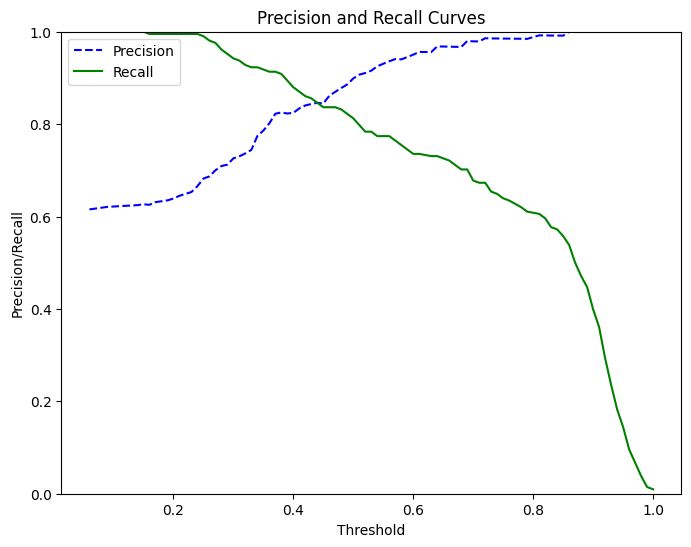

In [ ]:
#@title #12- Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.title('Precision and Recall Curves')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend(loc='upper left')
plt.ylim([0, 1])
plt.show()

In [ ]:
#@title #13- Finding the best threshold for maximum F1 score
optimal_idx = np.argmax(precisions * recalls)  # F1 optimization
optimal_threshold = thresholds[optimal_idx]

In [ ]:
#@title 14- Print sample of prediction against actual calsses
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np

# Assuming 'pipeline', 'X_test', 'y_test', 'precisions', 'recalls', and 'thresholds' are defined

# Finding the best threshold for maximum F1 score
optimal_idx = np.argmax(precisions * recalls)  # F1 optimization
optimal_threshold = thresholds[optimal_idx]

# Slider widget for number of rows to display
num_rows_slider = widgets.IntSlider(
    value=10,
    min=1,
    max=50,
    step=1,
    description='Num Rows:',
    continuous_update=False,
)

# Button to predict and display table
predict_button = widgets.Button(description="Predict and Create Table")

output_predict = widgets.Output()

def predict_and_create_table(button):
    with output_predict:
        clear_output()
        num_rows = num_rows_slider.value
        y_probs = pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_probs >= optimal_threshold).astype(int)

        table_data = {
            "Proposal": X_test[:num_rows],
            "Actual Class": y_test[:num_rows],
            "Predicted Class": y_pred[:num_rows]
        }

        table_df = pd.DataFrame(table_data)

        print("Table of proposals with their actual and predicted classes:")
        display(table_df)

predict_button.on_click(predict_and_create_table)

# Display the widgets and button
display(num_rows_slider, predict_button, output_predict)


IntSlider(value=10, continuous_update=False, description='Num Rows:', max=50, min=1)

Button(description='Predict and Create Table', style=ButtonStyle())

Output()

In [ ]:
#@title # 15- Apply the new threshold
y_pred_adj = (y_probs >= optimal_threshold).astype(int)

In [ ]:
#@title #16-  Final evaluation
from IPython.display import display, HTML

# Final evaluation
print("\nAdjusted Classification Report:")
# print(classification_report(y_test, y_pred_adj, target_names=['Rejected', 'Approved']))

# Create a DataFrame for the classification report
report = classification_report(y_test, y_pred_adj, target_names=['Rejected', 'Approved'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Display the classification report as a styled table
styled_report = report_df.style.set_table_styles(
    [{'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]},
     {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('text-align', 'center')]},
     {'selector': 'td', 'props': [('text-align', 'center')]}]
).set_properties(**{'border': '1px solid black', 'padding': '5px'})

display(HTML(styled_report.to_html()))


Adjusted Classification Report:


,precision,recall,f1-score,support
Rejected,0.906542,0.866071,0.885845,112.000000
Approved,0.918033,0.943820,0.930748,178.000000
accuracy,0.913793,0.913793,0.913793,0.913793
macro avg,0.912287,0.904946,0.908296,290.000000
weighted avg,0.913595,0.913793,0.913406,290.000000


In [ ]:
#@title 17- Save the trained model to disk for later use
joblib.dump(pipeline, 'proposal_classification_model.pkl')

['proposal_classification_model.pkl']

# Live Classification

In [ ]:
#@title 1- Import Lib

!pip install PyPDF2
import os
import json
import PyPDF2
import joblib
from sklearn.pipeline import Pipeline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.7 MB/s eta 0:00:00


In [ ]:
#@title #2-  Load the trained model
model = joblib.load('proposal_classification_model.pkl')

In [ ]:
#@title #3- Function to extract text based on file type
def extract_text(file_path):
    if file_path.endswith('.pdf'):
        text = extract_text_from_pdf(file_path)
    elif file_path.endswith('.json'):
        text = extract_text_from_json(file_path)
    else:
        raise ValueError("Unsupported file type. Please provide a .pdf or .json file.")
    return text.strip()

In [ ]:
#@title #4-  Extract text from PDF
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in reader.pages:
            text += page.extract_text() or ''  # Concatenate text, handle None
    return text

In [ ]:
#@title #5- Extract text from JSON
def extract_text_from_json(json_path):
    with open(json_path, 'r') as file:
        content = json.load(file)
    return content.get('ExtractedText', '').replace('\n', ' ')

In [ ]:
#@title #6- Function to classify all proposals in a given folder
def classify_all_proposals(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if the file is PDF or JSON before proceeding
        if file_path.endswith('.pdf') or file_path.endswith('.json'):
            try:
                text = extract_text(file_path)  # Utilize the existing extract_text function
                # Get the probability of being 'Approved'
                score = model.predict_proba([text])[0][1]
                classification = 'Approved' if score >= 0.5 else 'Rejected'
                print(f"Proposal: {filename}")
                print(f"Classification: {classification}, Score: {score:.2f}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

In [ ]:
#@title #7- Specify the folder containing your proposal files
folder_path = '/content/drive/Shareddrives/TDM Project - Sheikha Al Mujaini/2023/IG/Approved'


8- See The Classification of the new Proposals

In [ ]:
classify_all_proposals(folder_path)

Proposal: 90ccd7ad-34fb-4fb4-8e68-4358aee6b63d.pdf
Classification: Approved, Score: 0.75
Proposal: bc4d151c-d8eb-4e58-9a47-d77f70d0c60c.pdf
Classification: Approved, Score: 0.71
Proposal: 7b8b302e-86f0-4aba-b0ab-0ab3943fd01a.pdf
Classification: Approved, Score: 0.75
Proposal: 4b81228a-59e3-450b-aa7b-ee2b62e33636.pdf
Classification: Approved, Score: 0.69
Proposal: c11ec4ae-c4b9-4e2d-85dc-c75f404f8703.pdf
Classification: Approved, Score: 0.72
Proposal: d2e6f389-bfef-48b3-84b5-8d9fff08241c.pdf
Classification: Approved, Score: 0.81
Proposal: 3e707d01-ac18-46a4-aeaa-ae0f950900b4.pdf
Classification: Approved, Score: 0.76
Proposal: 66e1cc49-5c37-4aeb-9c8b-71b07c78ab36.pdf
Classification: Approved, Score: 0.83
Proposal: 11acb406-2e90-4efe-ba23-42d8c2ba755f.pdf
Classification: Approved, Score: 0.86
Proposal: 490c7d5e-355a-4f88-a58a-913f903cdf89.pdf
Classification: Approved, Score: 0.63
Proposal: 73a212d3-b042-4e0b-a380-0597d8d1ff68.pdf
Classification: Approved, Score: 0.75
Proposal: 6dbbfc47-d8

KeyboardInterrupt: 

In [ ]:
# Specify the folder containing your proposal files
folder_path = '/content/drive/Shareddrives/TDM Project - Sheikha Al Mujaini/2023/IG/Rejected'

In [ ]:
classify_all_proposals(folder_path)

Proposal: d8419f15-0e8a-43af-861b-d4e9070d6de8.pdf
Classification: Rejected, Score: 0.27
Proposal: 3e4920e2-7867-47c8-91d0-970b9d1bb938.pdf
Classification: Approved, Score: 0.83
Proposal: d6603fec-5160-44dd-944f-308b8b978a11.pdf
Classification: Approved, Score: 0.66
Proposal: 3651784b-ec7f-4cc3-ad25-62282d9b333a.pdf
Classification: Approved, Score: 0.99
Proposal: 7b5935b7-5f56-4b6a-bdba-5b70176b43ef.pdf
Classification: Approved, Score: 0.71
Proposal: dd1ff1b5-2355-4b6d-977b-0cf9b775fcde.pdf
Classification: Approved, Score: 0.72
Proposal: d5235d77-73a1-4a6c-859a-0f2056884110.pdf
Classification: Approved, Score: 0.78
Proposal: b411f084-6eee-4c10-b350-0725b43a3ead.pdf
Classification: Approved, Score: 0.74
Proposal: 5f4561ad-179f-4e39-9f75-475494579337.pdf
Classification: Approved, Score: 0.77
Proposal: c57c6fac-7a98-4fc4-a5dc-c3c1941f264e.pdf
Classification: Approved, Score: 0.87
Proposal: 4629f233-96e6-419f-95b9-960a1cbf5064.pdf
Classification: Approved, Score: 0.76
Proposal: 1dcf673b-b1

KeyboardInterrupt: 

In [ ]:
#@title #9- Define paths to 'Approved' and 'Rejected' folders
approved_folder_path = '/content/drive/Shareddrives/TDM Project - Sheikha Al Mujaini/2023/IG/Approved'
rejected_folder_path = '/content/drive/Shareddrives/TDM Project - Sheikha Al Mujaini/2023/IG/Rejected'

In [ ]:
#@title 10- Evaluation
def evaluate_proposals(folder_path, true_label):
    predictions, labels = [], []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if the file is PDF or JSON before proceeding
        if file_path.endswith('.pdf') or file_path.endswith('.json'):
            try:
                text = extract_text(file_path)  # Utilize the existing extract_text function
                score = model.predict_proba([text])[0][1]
                prediction = 1 if score >= 0.6 else 0  # Convert 'Approved'/'Rejected' to binary labels
                predictions.append(prediction)
                labels.append(1 if true_label == 'Approved' else 0)  # True label in binary form
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    return predictions, labels

In [ ]:
#@title #11- Get predictions and true labels
approved_predictions, approved_labels = evaluate_proposals(approved_folder_path, 'Approved')
rejected_predictions, rejected_labels = evaluate_proposals(rejected_folder_path, 'Rejected')


In [ ]:
#@title #12- Combine predictions and labels from both folders
all_predictions = approved_predictions + rejected_predictions
all_labels = approved_labels + rejected_labels

In [ ]:
#@title #13- Calculate and print performance metrics
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['Rejected', 'Approved']))
print("Accuracy:", accuracy_score(all_labels, all_predictions))

Classification Report:
              precision    recall  f1-score   support

    Rejected       0.44      0.16      0.24        25
    Approved       0.84      0.96      0.89       114

    accuracy                           0.81       139
   macro avg       0.64      0.56      0.56       139
weighted avg       0.77      0.81      0.78       139

Accuracy: 0.8129496402877698


# Similarity To Oman Vision 2040 and SQU's objectives

In [ ]:
#@title #1- Import necessary libraries
import os
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import joblib
import torch
from transformers import BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity

# Load tokenizer and model for Multilingual BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
#@title 2- Gettign bert embedding & calculate similarity functions
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.pooler_output[0].numpy()

def calculate_similarity(vec1, vec2):
    return cosine_similarity([vec1], [vec2])[0][0]

# Function to extract text based on file type
def extract_text(file_path):
    if file_path.endswith('.pdf'):
        text = extract_text_from_pdf(file_path)
    elif file_path.endswith('.json'):
        text = extract_text_from_json(file_path)
    else:
        raise ValueError("Unsupported file type. Please provide a .pdf or .json file.")
    return text.strip()


In [ ]:
#@title #3- Strategic priorities of Oman Vision 2040 and SQU focus areas

import ipywidgets as widgets
from IPython.display import display, clear_output


strategic_texts = {
    "oman_vision_2040": {
        "1": "الرفاه والحماية الاجتماعية: مجتمع مغطى بشبكة أمان اجتماعية فاعلة ومستدامة وعادلة؛ مجتمع واع متماسك ممكن اجتماعيا واقتصاديا، خاصة المرأة والطفل والشباب وذوي الإعاقة والفئات الأكثر احتياجا؛ خدمات وبرامج اجتماعية متطورة ملبية لاحتياجات المجتمع؛ حماية اجتماعية متكاملة؛ موجهة للفئات الأكثر احتياجا لتمكينها من الاعتماد على الذات، والمساهمة في الاقتصاد الوطني؛ بيئة وأنظمة محفزة لرياضة مساهمة اقتصاديا ومنافسة عالميا؛ مجتمع مدني ممكن ومشارك بفاعلية في التنمية المستدامة وإطار تنظيمي فاعل ومحفز لعمل مؤسساته؛ شراكة فاعلة بين القطاع الحكومي والقطاع الخاص، والمجتمع المدني في مجالات التنمية الاجتماعية.",
        "2": "المواطنة والهوية والتراث والثقافة الوطنية: مجتمع معتز بهويته ومواطنته وثقافته، يعمل على المحافظة على تراثه، وتوثيقه، ونشره عالميا؛ منظومة شراكة مجتمعية مؤسسية متكاملة تعزز الهوية، والمواطنة، والترابط والتكافل الاجتماعي؛ مجتمع معرفي واع يحافظ على هويته، ذو مهارات وقدرات، ويواكب المستجدات المعرفية والمتغيرات التقنية؛ استثمار مستدام للتراث والثقافة والفنون، يسهم في نمو الاقتصاد الوطني؛ إعلام مهني معزز للوعي المجتمعي ومساهم في التنمية الاجتماعية والاقتصادية؛ مجتمع أفراده يتصفون بالمسؤولية مدركون لحقوقهم، وملتزمون بواجباتهم؛ مجتمع رائد عالميا في التفاهم والتعايش والسلام؛ مجتمع متمكن من تقييم المعرفة ونقدها وتوظيفها وإنتاجها ونشرها.",
        "3": "الصحة: مجتمع يتمتع بصحة مستدامة تترسخ فيه ثقافة «الصحة مسؤولية الجميع» ومصان من الأخطار ومهددات الصحة؛ نظام صحي يتسم باللامركزية، والجودة، والشفافية، والعدالة، والمساءلة؛ مصادر تمويل متنوعة ومستدامة للنظام الصحي؛ أنظمة وخدمات طبية تقنية، ورعاية صحية وقائية وعلاجية ذات جودة عالية بجميع مستوياتها؛ كوادر وقدرات وطنية مؤهلة، ورائدة في البحث العلمي والابتكار الصحي.",
        "4": "التعليم والتعلم والبحث العلمي والقدرات الوطنية: نظام تعليمي يتسم بالجودة العالية، والشراكة المجتمعية؛ نظام متكامل ومستقل لحوكمة المنظومة التعليمية وتقييمها وفق المعايير الوطنية والعالمية؛ مناهج تعليمية معززة للقيم، ومراعية لمبادئ الدين الإسلامي، والهوية العمانية، ومستلهمة من تاريخ عمان وتراثها، ومواكبة لمتطلبات التنمية المستدامة، ومهارات المستقبل، وتدعم تنوعا في المسارات التعليمية؛ كفاءات وطنية ذات قدرات ومهارات ديناميكية منافسة محليا وعالميا؛ مصادر تمويل متنوعة ومستدامة للتعليم والبحث العلمي والابتكار؛ منظومة وطنية فاعلة للبحث العلمي والإبداع والابتكار تسهم في بناء اقتصاد المعرفة ومجتمعها؛ نظام ممكن للقدرات البشرية في قطاع التعليم.",
        "5": "حوكمة الجهاز الإداري للدولة والموارد والمشاريع: أداء وخدمات حكومية بجودة عالية؛ قرارات حكومية ذات توازن وموثوقية؛ قطاع حكومي فعال في مجال التخطيط والتنظيم والمتابعة والتقويم ذو هيكلة قطاعية ويستشرف المستقبل؛ حوكمة فاعلة للموارد والمشاريع؛ شراكة متوازنة ومستدامة وأدوار متكاملة بين أطراف العلاقة من القطاعين الحكومي والخاص والمجتمع المدني والأفراد لضمان أداء مؤسسي فعال؛ شفافية وإفصاح مؤسسي راسخ يكفل حق الوصول للمعلومات؛ معايير تنافسية واضحة لشغل المناصب القيادية في القطاع الحكومي والمؤسسات التابعة له.",
        "6": "التشريع والقضاء والرقابة: نظام رقابي شامل يحمي المقدرات الوطنية ويحقق مبادئ المساءلة والمحاسبة؛ وسائل فاعلة بديلة للقضاء تجعل من السلطنة مركزا دوليا؛ قضاء ناجز، نزيه، ومتخصص يوظف تقنيات المستقبل؛ تشريعات مرنة وسلطة تشريعية مستقلة ذات صلاحيات كاملة؛ كفاءات وطنية تشريعية وقضائية ورقابية متخصصة ومؤهلة تحقق الثقة وتعمل في بيئة جاذبة؛ مجتمع واع قانونيا ومشارك بفاعلية في التشريع والرقابة؛ نظام رقابي فاعل ومستقل يوظف الشفافية والإفصاح ويكافح الفساد، ودور رقابي بصير وفاعل للإعلام.",
        "7": "البيئة والموارد الطبيعية: بيئة تحقق التوازن بين المتطلبات البيئية والاقتصادية والاجتماعية والعمل بقواعد التنمية المستدامة؛ أوساط بيئية ذات جودة عالية وخالية من التلوث؛ أمن غذائي ومائي قائم على موارد متجددة وتقنيات متطورة واستغلال أمثل للموقع الاستراتيجي والتنوع الأحيائي للسلطنة؛ وعي بيئي ملازم للتطبيق الفعال لقواعد الاستهلاك والإنتاج المستدامين؛ اقتصاد أخضر ودائري يستجيب للاحتياجات الوطنية وينسجم مع التوجه العالمي؛ طاقة متجددة ومصادر متنوعة وترشيد للاستهلاك لتحقيق أمن الطاقة؛ استخدام مستدام للموارد والثروات الطبيعية واستثمارها بما يكفل تحقيق قيمة مضافة عالية.",
        "8": "تنمية المحافظات والمدن المستدامة: تنمية متوازنة وعادلة تعزز الميزة النسبية والتنافسية للحواضر والمحافظات؛ مجتمعات ممكنة تسهم في صياغة أولوياتها الاجتماعية والاقتصادية والبيئية وتعمل ضمن إطار اللامركزية الإدارية والاقتصادية؛ نظام تسلسل هرمي للتجمعات السكانية فعال يوجه التنمية الحضرية المستدامة لاستيعاب النمو السكاني المتنامي ويوفر الخدمات والمرافق الأساسية؛ وسائل نقل متنوعة وسهلة الوصول، متكاملة مع التنمية العمرانية الموجهة بشكل سليم، وبنية أساسية مستدامة عالمية المستوى؛ مدن ذكية ومستدامة نابضة بالحياة وريف حيوي بجودة عمرانية عالية للمعيشة والعمل والترفيه؛ مناطق حضرية وريفية وتراث طبيعي وثقافي تتميز بمرونة وقدرة عالية على التعامل مع التغيرات المناخية.",
        "9": "القطاع الخاص والاستثمار والتعاون الدولي: بيئة أعمال تنافسية وجاذبة للاستثمار تمارس فيها الحكومة الدور التنظيمي المقترن بكفاءة وسلاسة إدارية ناجعة؛ أنماط تمويل مرنة وميسرة تواكب المستجدات العالمية وتلبي الاحتياجات الاستثمارية؛ قطاع خاص ممكن وتنافسي يقود الاقتصاد ويراعي الأبعاد الاجتماعية والبيئية؛ شراكة وتكاملية بين المؤسسات الصغيرة والمتوسطة تحتضنها مؤسسات كبيرة؛ هوية اقتصادية فريدة تتكامل مع سلاسل الإنتاج والخدمات العالمية؛ صادرات وواردات متنوعة سلعيا وجغرافيا تزيد من القدرة على توظيف مكانة السلطنة الدولية وموقعها الجغرافي؛ شراكة فاعلة بين القطاعين الحكومي والخاص تحسن الكفاءة الإنتاجية وإطار حوكمة ينظم خصخصة المشاريع والخدمات العامة.",
        "10": "سوق العمل والتشغيل: سوق عمل بقوى بشرية ذات مهارات وإنتاجية عالية وثقافة عمل إيجابية؛ سوق عمل جاذب للكفاءات والعمالة الماهرة ضمن سياسات استقطاب واضحة المعالم والمعايير؛ قوانين وتشريعات ناظمة لسوق العمل وفق معايير مهنية وبيئة عمل محفزة مستجيبة للمتغيرات؛ منظومة تشغيل، وتأهيل، وترقيات وحوافز مبنية على الكفاءة والإنتاجية، تذكي روح المبادرة والابتكار.",
        "11": "التنويع الاقتصادي والاستدامة المالية: قطاعات قاطرة للتنويع الاقتصادي وأخرى متكاملة معها يتم تحديدها كل خمس سنوات؛ اقتصاد تنافسي متنوع ومتكامل وقائم على استشراف المستقبل والابتكار وريادة الأعمال؛ سياسات مالية ونقدية واقتصادية مستنيرة متكاملة ومستدامة وموازنات توظف الإيرادات العامة بفعالية؛ منظومة بحث وتطوير مترابطة بين مختلف القطاعات والمؤسسات؛ بنية أساسية وتقنية متطورة ممكنة لجميع القطاعات وقادرة على استيعاب المستجدات، وتحديات الأمن السيبراني؛ بيئة تنظيمية وتشريعات ذات حاكمية تتصف بالتجدد والمرونة ومواكبة المستجدات وضامنة لتكافؤ الفرص.",
        "12": "القيادة والإدارة الاقتصادية: جهة مرجعية ممكنة للشأن الاقتصادي تعمل لتحقيق غايات التنمية الاقتصادية والعدالة الاجتماعية وحماية البيئة؛ قيادة اقتصادية فعالة بصلاحيات ملزمة ذات مهام واضحة وسريعة الاستجابة للاحتياجات التنموية وفقا لمؤشرات أداء محددة؛ منظومة تشريعات اقتصادية فعالة وممكنة تواكب المتغيرات؛ إدارات عليا متجددة قائمة على كفاءات تناسب ديناميكية السوق والتوقعات المستقبلية والتغيرات المتسارعة."
    },

    "squ_focus_2021_2025": [
        "جودة المخرجات",
        "البحث العلمي والابتكار",
        "بناء الشراكات",
        "الاستدامة المالية",
        "الحوكمة والاداء المؤسسي"
    ]
}




In [ ]:
#@title 4- Load the trained model
pipeline = joblib.load('proposal_classification_model.pkl')

In [ ]:
#@title 5- Function to classify all proposals in a given folder and calculate similarity
def classify_all_proposals(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if file_path.endswith('.pdf') or file_path.endswith('.json'):
            try:
                text = extract_text(file_path)

                # Classify using the trained RandomForest model
                score = pipeline.predict_proba([text])[0][1]
                classification = 'Approved' if score >= 0.5 else 'Rejected'

                if classification == 'Approved':
                    # Get BERT embeddings for the proposal
                    proposal_embedding = get_bert_embeddings(text)

                    # Calculate similarity with Oman Vision 2040 and SQU focus areas
                    oman_similarity = max( #I should here return the average of the similarity not the max of the values
                        calculate_similarity(proposal_embedding, get_bert_embeddings(value))
                        for key, value in strategic_texts['oman_vision_2040'].items()
                    )
                    squ_similarity = max(# same as the above, i should return the average of the all similarities not just the max.
                        calculate_similarity(proposal_embedding, get_bert_embeddings(focus))
                        for focus in strategic_texts['squ_focus_2021_2025']
                    )

                    print(f"Proposal: {filename}")
                    print(f"Classification: {classification}, Score: {score:.2f}")
                    print(f"Similarity to Oman Vision 2040: {oman_similarity:.2f}")
                    print(f"Similarity to SQU Focus Areas: {squ_similarity:.2f}")
                else:
                    print(f"Proposal: {filename}")
                    print(f"Classification: {classification}, Score: {score:.2f}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

6- Specify the Path to your Proposals

In [ ]:
# Path:
folder_path = '/content/drive/Shareddrives/TDM Project - Sheikha Al Mujaini/2023/IG/Approved'

In [ ]:
# Example use:
classify_all_proposals(folder_path)

Proposal: 90ccd7ad-34fb-4fb4-8e68-4358aee6b63d.pdf
Classification: Approved, Score: 0.82
Similarity to Oman Vision 2040: 0.91
Similarity to SQU Focus Areas: 0.93
Proposal: bc4d151c-d8eb-4e58-9a47-d77f70d0c60c.pdf
Classification: Approved, Score: 0.69
Similarity to Oman Vision 2040: 0.92
Similarity to SQU Focus Areas: 0.93
Proposal: 7b8b302e-86f0-4aba-b0ab-0ab3943fd01a.pdf
Classification: Approved, Score: 0.60
Similarity to Oman Vision 2040: 0.93
Similarity to SQU Focus Areas: 0.94
Proposal: 4b81228a-59e3-450b-aa7b-ee2b62e33636.pdf
Classification: Approved, Score: 0.65
Similarity to Oman Vision 2040: 0.87
Similarity to SQU Focus Areas: 0.90
Proposal: c11ec4ae-c4b9-4e2d-85dc-c75f404f8703.pdf
Classification: Approved, Score: 0.64
Similarity to Oman Vision 2040: 0.88
Similarity to SQU Focus Areas: 0.92
Proposal: d2e6f389-bfef-48b3-84b5-8d9fff08241c.pdf
Classification: Approved, Score: 0.75
Similarity to Oman Vision 2040: 0.93
Similarity to SQU Focus Areas: 0.93
Proposal: 3e707d01-ac18-46a4

KeyboardInterrupt: 

In [ ]:
#@title 7- Function to calculate similarity for each priority
def calculate_priorities_similarity(proposal_embedding, strategic_texts):
    similarities = {}
    for key, value in strategic_texts["oman_vision_2040"].items():
        similarity = calculate_similarity(proposal_embedding, get_bert_embeddings(value))
        similarities[key] = similarity
    return similarities

def calculate_squ_similarity(proposal_embedding, squ_focus):
    similarities = {}
    for idx, focus in enumerate(squ_focus, start=1):
        similarity = calculate_similarity(proposal_embedding, get_bert_embeddings(focus))
        similarities[str(idx)] = similarity
    return similarities

In [ ]:
#@title 8- Function to classify all proposals in a given folder and calculate similarity
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output


def classify_all_proposals(folder_path):
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if file_path.endswith('.pdf') or file_path.endswith('.json'):
            try:
                text = extract_text(file_path)

                # Classify using the trained model
                score = model.predict_proba([text])[0][1]
                classification = 'Approved' if score >= 0.5 else 'Rejected'

                if classification == 'Approved':
                    # Get BERT embeddings for the proposal
                    proposal_embedding = get_bert_embeddings(text)

                    # Calculate similarity with Oman Vision 2040 and SQU focus areas
                    oman_similarities = calculate_priorities_similarity(proposal_embedding, strategic_texts)
                    squ_similarities = calculate_squ_similarity(proposal_embedding, strategic_texts['squ_focus_2021_2025'])

                    # Print the detailed report
                    print(f"Proposal: {filename}")
                    print(f"Classification: {classification}, Score: {score:.2f}")
                    print("Similarity to Oman Vision 2040:")
                    for key, similarity in oman_similarities.items():
                        print(f"  Priority {key}: {similarity:.2f}")
                    print("Similarity to SQU Focus Areas:")
                    for key, similarity in squ_similarities.items():
                        print(f"  Focus {key}: {similarity:.2f}")
                else:
                    print(f"Proposal: {filename}")
                    print(f"Classification: {classification}, Score: {score:.2f}")
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

#keys
For Oman Vision 2040:
1.	الرفاه والحماية الاجتماعيـة
2.	المواطنة والهوية والتراث والثقافة الوطنية
3.	الصحة
4.	التعليم والتعلم والبحث العلمي والقدرات الوطنية
5.	حوكمة الجهاز الإداري للدولة والموارد والمشاريع
6.	التشريع والقضاء والرقابة
7.	البيئة والموارد الطبيعية
8.	تنمية المحافظات والمدن المستدامة
9.	القطاع الخاص والاستثمار والتعاون الدولي
10.	سوق العمل والتشغيل
11.	التنويع الاقتصادي والاستدامة المالية
12.	القيادة والإدارة الاقتصادية

for SQU:
1. جودة المخرجات
2. البحث العلمي والابتكار
3. بناء الشراكات
4. الاستدامة المالية
5. الحوكمة والاداء المؤسسي



In [ ]:
# Example use:
classify_all_proposals(folder_path)

Proposal: 90ccd7ad-34fb-4fb4-8e68-4358aee6b63d.pdf
Classification: Approved, Score: 0.82
Similarity to Oman Vision 2040:
  Priority 1: 0.90
  Priority 2: 0.24
  Priority 3: 0.90
  Priority 4: 0.91
  Priority 5: 0.85
  Priority 6: 0.85
  Priority 7: 0.89
  Priority 8: 0.90
  Priority 9: 0.76
  Priority 10: 0.89
  Priority 11: 0.72
  Priority 12: 0.88
Similarity to SQU Focus Areas:
  Focus 1: 0.90
  Focus 2: 0.90
  Focus 3: 0.88
  Focus 4: 0.93
  Focus 5: 0.80
Proposal: bc4d151c-d8eb-4e58-9a47-d77f70d0c60c.pdf
Classification: Approved, Score: 0.69
Similarity to Oman Vision 2040:
  Priority 1: 0.92
  Priority 2: 0.27
  Priority 3: 0.92
  Priority 4: 0.92
  Priority 5: 0.89
  Priority 6: 0.89
  Priority 7: 0.92
  Priority 8: 0.92
  Priority 9: 0.84
  Priority 10: 0.91
  Priority 11: 0.81
  Priority 12: 0.91
Similarity to SQU Focus Areas:
  Focus 1: 0.91
  Focus 2: 0.91
  Focus 3: 0.91
  Focus 4: 0.93
  Focus 5: 0.85
Proposal: 7b8b302e-86f0-4aba-b0ab-0ab3943fd01a.pdf
Classification: Approve

KeyboardInterrupt: 